In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score, precision_recall_curve
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

df = pd.read_csv("famcs_students.csv")

binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
N = 2
target = binary_cols[N % 8]
print("target =", target)

X = df.drop(columns=[target]).copy()
y = df[target].copy()

for col in X.columns:
    if X[col].dtype.kind in 'biufc':
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode().iloc[0])
        if X[col].dtype == 'object' or str(X[col].dtype).startswith('category'):
            X[col] = X[col].astype('category').cat.codes

mask = ~y.isna()
X = X[mask]
y = y[mask]
if y.dtype != int and y.dtype != bool:
    if set(y.unique()) <= {0,1}:
        y = y.astype(int)
    else:
        y = y.astype('category').cat.codes

mi = mutual_info_classif(X.fillna(0), y, discrete_features='auto', random_state=0)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
selected_features = mi_series.head(5).index.tolist()
X_sel = X[selected_features]

ModuleNotFoundError: No module named 'matplotlib.backends.registry'

Предобработка (пропуски обработал и кодирование сделал)

In [27]:
for col in X.columns:
    if X[col].dtype.kind in 'biufc':
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode().iloc[0])
        if X[col].dtype == 'object' or str(X[col].dtype).startswith('category'):
            X[col] = X[col].astype('category').cat.codes

mask = ~y.isna()
X = X[mask]
y = y[mask]
if y.dtype != int and y.dtype != bool:
    if set(y.unique()) <= {0,1}:
        y = y.astype(int)
    else:
        y = y.astype('category').cat.codes

mi = mutual_info_classif(X.fillna(0), y, discrete_features='auto', random_state=0)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
selected_features = mi_series.head(5).index.tolist()
X_sel = X[selected_features]

X_sel

,social,foot_size,age,eye_color,hostel
0,2,48.0,20.0,2,1
1,2,39.0,20.0,1,1
2,2,41.0,19.0,2,1
3,2,36.0,20.0,2,1
4,0,46.0,20.0,1,1
...,...,...,...,...,...
122,2,45.0,20.0,2,1
123,0,39.0,22.0,2,2
124,2,44.0,21.0,2,1
125,0,45.0,20.0,2,2


Разделяем выборку

In [28]:
X_temp, X_test, y_temp, y_test = train_test_split(X_sel, y, test_size=0.15, random_state=42, stratify=y)
val_size = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42, stratify=y_temp)

Тривиальный классификатор (самый частый класс всегда дает)

In [29]:
class TrivialClassifier:
    def fit(self, X, y):
        self.most_common = int(y.value_counts().idxmax())
    def predict(self, X):
        return np.array([self.most_common]*len(X))
    def predict_proba(self, X):
        if self.most_common == 1:
            return np.vstack([1 - np.ones(len(X))*1e-9, np.ones(len(X))]).T
        else:
            return np.vstack([np.ones(len(X)), 1e-9*np.ones(len(X))]).T
triv = TrivialClassifier(); triv.fit(X_train, y_train)

Наивный байесовский классификатор
(дискретизирую призанки по медиане, считаем P для всех классов и признаков с Лапл сглаж альфа)
(логарифм правдоподобия, получаем вероятности, берем класс с макс P)

In [30]:
class ManualBernoulliNB:
    def fit(self, X, y, alpha=1.0):
        self.feature_names = X.columns.tolist()
        Xb = (X > X.median()).astype(int)
        self.Xb_median_ = X.median()
        self.alpha = alpha
        classes = np.unique(y)
        self.classes_ = classes
        self.class_count_ = {}
        self.feature_prob_ = {}
        for c in classes:
            yc = (y == c)
            self.class_count_[c] = yc.sum()
            probs = (Xb[yc].sum(axis=0) + alpha) / (yc.sum() + 2*alpha)
            self.feature_prob_[c] = probs.values
        self.total_count_ = len(y)
        self.class_log_prior_ = {c: np.log(self.class_count_[c]/self.total_count_) for c in classes}
    def predict_log_proba(self, X):
        Xb = (X > self.Xb_median_).astype(int)
        res = np.zeros((len(Xb), len(self.classes_)))
        for i,c in enumerate(self.classes_):
            p = self.feature_prob_[c]
            log_likelihood = (Xb * np.log(p + 1e-12)).sum(axis=1) + ((1 - Xb) * np.log(1 - p + 1e-12)).sum(axis=1)
            res[:, i] = self.class_log_prior_[c] + log_likelihood
        return res
    def predict_proba(self, X):
        logp = self.predict_log_proba(X)
        a = np.exp(logp - logp.max(axis=1, keepdims=True))
        probs = a / a.sum(axis=1, keepdims=True)
        return probs
    def predict(self, X):
        probs = self.predict_proba(X)
        class_order = list(self.classes_)
        preds = [class_order[i] for i in np.argmax(probs, axis=1)]
        return np.array(preds, dtype=int)
nb = ManualBernoulliNB(); nb.fit(X_train, y_train, alpha=1.0)

Метод k-ближайших соседей (нет обучения - сохраняем набор данных)
(считаем расстояние между x и каждой точкой X из сохр данных, берем к ближ соседей, считаем кол-во соседей каждог класса, берем класс с макс кол-вом)
(перебираем нечет к от 1-25, на валидац выборке считаем разыне f1 меры, берем K, для кот f1 макс)

In [ ]:
class ManualKNN:
    def __init__(self, k=3):
        self.k = k
    def fit(self, X, y):
        self.X = X.values.astype(float); self.y = y.values.astype(int)
    def _predict_point(self, x):
        dists = np.sqrt(((self.X - x)**2).sum(axis=1))
        idx = np.argsort(dists)[:self.k]
        votes = self.y[idx]
        counts = np.bincount(votes)
        return np.argmax(counts)
    def predict(self, X):
        Xv = X.values.astype(float)
        return np.array([self._predict_point(x) for x in Xv])
    def predict_proba(self, X):
        Xv = X.values.astype(float)
        probs = []
        for x in Xv:
            dists = np.sqrt(((self.X - x)**2).sum(axis=1))
            idx = np.argsort(dists)[:self.k]
            votes = self.y[idx]
            cnt = np.bincount(votes, minlength=2)
            prob1 = cnt[1] / cnt.sum()
            probs.append([1-prob1, prob1])
        return np.array(probs)

ks = list(range(1,26,2))
best_k = None; best_f1 = -1
for k in ks:
    clf = ManualKNN(k=k); clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    f1 = f1_score(y_val, preds, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1; best_k = k
knn = ManualKNN(k=best_k); knn.fit(X_train, y_train)


 Логистическая регрессия
 (lr - скорость спуска, с - коэф регул, берем вероятность класса 1 через сигмоиду 1/ 1 + e^-z, z - лин комб признаков, сравниваем с threshold, то есть порогом, преобр в предсказание 1/0)
 (берем вероятности класса 1 для валид выборки, считаем recall и precision для разных порогов, считаме f1 (2 prec rec / pre + rec), берем порог с макс f1)

In [32]:
class ManualLogisticRegression:
    def __init__(self, lr=0.1, n_iter=2000, C=1.0):
        self.lr = lr; self.n_iter = n_iter; self.C = C
    def fit(self, X, y):
        Xv = X.values.astype(float)
        self.mu = Xv.mean(axis=0); self.sigma = Xv.std(axis=0); self.sigma[self.sigma==0]=1.0
        Xs = (Xv - self.mu) / self.sigma
        Xs = np.hstack([np.ones((Xs.shape[0],1)), Xs])
        n, m = Xs.shape
        self.w = np.zeros(m); yv = y.values.astype(float)
        for it in range(self.n_iter):
            z = Xs.dot(self.w); pred = 1/(1+np.exp(-z))
            grad = Xs.T.dot(pred - yv)/n + (1/self.C)*np.hstack([0, self.w[1:]])/n
            self.w -= self.lr * grad
        self.coef_ = self.w[1:]; self.intercept_ = self.w[0]
    def predict_proba(self, X):
        Xv = X.values.astype(float)
        Xs = (Xv - self.mu) / self.sigma
        Xs = np.hstack([np.ones((Xs.shape[0],1)), Xs])
        z = Xs.dot(self.w)
        prob = 1/(1+np.exp(-z))
        return np.vstack([1-prob, prob]).T
    def predict(self, X, threshold=0.5):
        prob = self.predict_proba(X)[:,1]
        return (prob >= threshold).astype(int)

logreg = ManualLogisticRegression(lr=0.5, n_iter=3000, C=1.0)
logreg.fit(X_train, y_train)
probs_val = logreg.predict_proba(X_val)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_val, probs_val)
f1s = (2*precisions*recalls) / (precisions + recalls + 1e-12)
f1s_for_thresh = f1s[:-1]
best_idx = np.nanargmax(f1s_for_thresh)
best_threshold = thresholds[best_idx]

график зависимости метрик precision, recall от порога классификаци

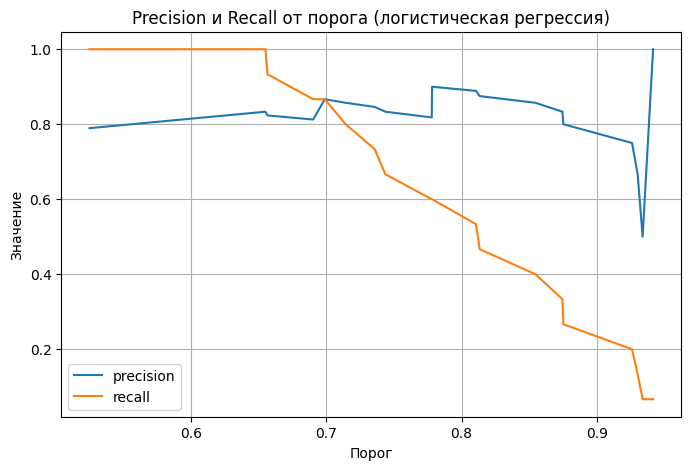

In [33]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])
plt.xlabel("Порог"); plt.ylabel("Значение")
plt.title("Precision и Recall от порога (логистическая регрессия)")
plt.legend(["precision","recall"])
plt.grid(True)
plt.show()

In [35]:
def evaluate(clf, X_test, y_test, name="model", threshold=None):
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test)[:,1]
    else:
        probs = None
    if threshold is None:
        preds = clf.predict(X_test)
    else:
        preds = (probs >= threshold).astype(int)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, probs) if probs is not None and len(np.unique(y_test))==2 else float('nan')
    cm = confusion_matrix(y_test, preds)
    print(f"{name}")
    print("accuracy:", acc, "precision:", prec, "recall:", rec, "roc-auc:", roc)
    print("confusion matrix:\n", cm)
    return {"accuracy":acc, "precision":prec, "recall":rec, "roc_auc":roc, "cm":cm}

results = {}
results['trivial'] = evaluate(triv, X_test, y_test, name="TrivialClassifier")
results['nb'] = evaluate(nb, X_test, y_test, name="ManualBernoulliNB")
results['knn'] = evaluate(knn, X_test, y_test, name=f"ManualKNN(k={best_k})")
results['logreg'] = evaluate(logreg, X_test, y_test, name="ManualLogisticRegression", threshold=best_threshold)

TrivialClassifier
accuracy: 0.8 precision: 0.8 recall: 1.0 roc-auc: 0.5
confusion matrix:
 [[ 0  4]
 [ 0 16]]
ManualBernoulliNB
accuracy: 0.8 precision: 0.8 recall: 1.0 roc-auc: 0.4296875
confusion matrix:
 [[ 0  4]
 [ 0 16]]
ManualKNN(k=5)
accuracy: 0.8 precision: 0.8 recall: 1.0 roc-auc: 0.546875
confusion matrix:
 [[ 0  4]
 [ 0 16]]
ManualLogisticRegression
accuracy: 0.75 precision: 0.7894736842105263 recall: 0.9375 roc-auc: 0.484375
confusion matrix:
 [[ 0  4]
 [ 1 15]]


In [17]:
print(df["interest"].value_counts())


interest
Программирование    103
Математика           24
Name: count, dtype: int64


precision = кол-во успешных предсказаний единиц / кол-во предсказанных единиц, то есть 100 раз предсказали 1, но реально из них только 80 ед
recall - пройент найденных 1

roc-auc - сколько 0 посчитали 1 и наоборот, то есть качесвто деления классов на 0 и 1

матрица:
TN FP
FN TP

TP - верная 1
FN - ложный 0, то есть реально 1, но предсказ 0
